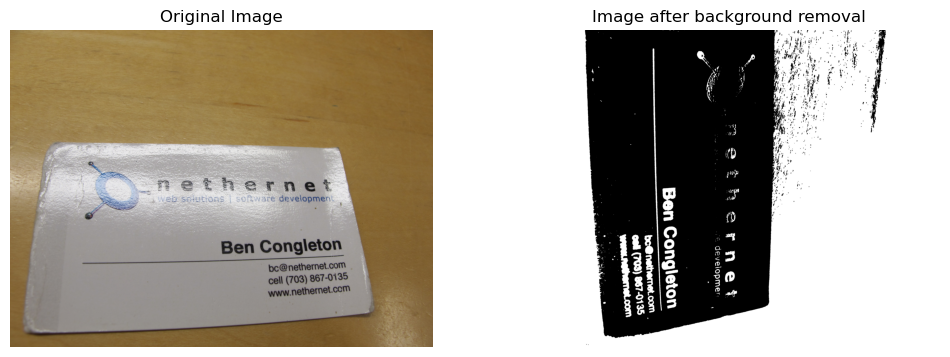

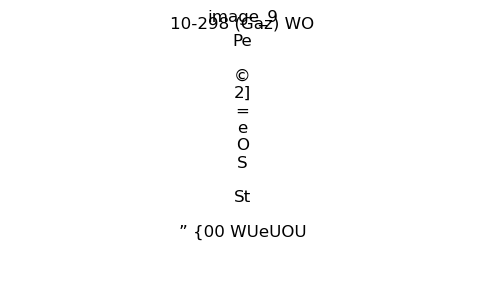

In [1]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import os

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# enter start and end range for which images to extract data from inside image_downloads folder in root directory
def main():
    imagePaths = createTestImagePaths(9, 9)
    for imagePath in imagePaths:
        title = extract_title_from_path(imagePath)
        text = performOCR(imagePath)
        write_text_to_file(title, text)

# Display side-by-side comparison using Matplotlib
def showImage(imageBefore, imageAfter, titleBefore, titleAfter, text='', textTitle=''):
    # Display side-by-side comparison using Matplotlib
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(imageBefore, cv2.COLOR_BGR2RGB))
    plt.title(titleBefore)
    plt.axis('off')

    # Image with background removed and extracted text as annotation
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(imageAfter, cv2.COLOR_BGR2RGB))
    plt.title(titleAfter)
    plt.axis('off')

    plt.figure(figsize=(6, 3))
    plt.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)
    plt.title(extract_title_from_path(textTitle))
    plt.axis('off')
    plt.show()

# Write the extracted text to a file
def write_text_to_file(title, text):
    # Create the 'extractedText' folder if it doesn't exist
    folder_path = 'extracted_text'
    os.makedirs(folder_path, exist_ok=True)

    # Create the file path using the provided title
    file_path = os.path.join(folder_path, f'{title}.txt')

    # Write the text to the file
    with open(file_path, 'w') as file:
        file.write(text)

# Extract the title from the file path
def extract_title_from_path(file_path):
    # Find the start and end indices of the relevant portion
    start_index = file_path.find("image_downloads/") + len("image_downloads/")
    end_index = file_path.find(".jpg")

    # Extract the substring
    title = file_path[start_index:end_index]

    return title

def preProcess(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve accuracy of contour detection
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding to emphasize the text
    _, binary_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations (dilation) to enhance text features
    kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(binary_img, kernel, iterations=1)

    # Invert the image to make the text appear dark on a light background
    inverted_img = cv2.bitwise_not(dilated_img)

    # Gamma correction (optional)
    gamma = 1.5  # You can adjust the gamma value
    gamma_corrected_img = np.power(inverted_img / 255.0, gamma) * 255.0
    gamma_corrected_img = gamma_corrected_img.astype(np.uint8)

    return gamma_corrected_img

# Perform OCR on the image
def performOCR(imagePath):
    image = cv2.imread(imagePath)

    # Use pytesseract on the result
    result = preProcess(image)
    text = pytesseract.image_to_string(result)

    # show image comparison with text extracted
    showImage(image, result, 'Original Image', 'Image after background removal', text, imagePath)

    return text

# Create a list of image paths
def createTestImagePaths(start, end):
    paths = []
    for i in range(start, end+1):
        paths.append('image_downloads/image_' + str(i) + '.jpg')
    return paths

main()